In [22]:
from __future__ import print_function
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer

from pyspark.sql.functions import count, desc , col, max, struct
import pandas as pd
import numpy as np
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [2]:
if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("churn_prediction")\
        .getOrCreate()

In [3]:
df = spark.read.csv("churn_prediction.csv",header=True)

In [6]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|  

In [5]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [7]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select(indexCol,'features','label')

In [8]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol,dropLast=False):

    '''
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df: the dataframe
    :param categoricalCols: the name list of the categorical data
    :param continuousCols:  the name list of the numerical data
    :param labelCol:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: feature matrix

    :author: Wenqiang Feng
    :email:  von198@gmail.com

    >>> df = spark.createDataFrame([
                  (0, "a"),
                  (1, "b"),
                  (2, "c"),
                  (3, "a"),
                  (4, "a"),
                  (5, "c")
              ], ["id", "category"])

    >>> indexCol = 'id'
    >>> categoricalCols = ['category']
    >>> continuousCols = []
    >>> labelCol = []

    >>> mat = get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol)
    >>> mat.show()

    >>>
        +---+-------------+
        | id|     features|
        +---+-------------+
        |  0|[1.0,0.0,0.0]|
        |  1|[0.0,0.0,1.0]|
        |  2|[0.0,1.0,0.0]|
        |  3|[1.0,0.0,0.0]|
        |  4|[1.0,0.0,0.0]|
        |  5|[0.0,1.0,0.0]|
        +---+-------------+
    '''

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()),dropLast=dropLast)
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    if indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select(indexCol,'features','label')
    elif not indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select('features','label')
    elif indexCol and not labelCol:
        # for unsupervised learning
        return data.select(indexCol,'features')
    elif not indexCol and not labelCol:
        # for unsupervised learning
        return data.select('features')

In [9]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')


In [10]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [12]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [ ]:
['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [14]:
catcols = [
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

num_cols = []
labelCol = 'Churn'

data = get_dummy(df,catcols,num_cols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(8213,[1,3,4,80,8...|   No|
|(8213,[0,1,2,3,59...|   No|
|(8213,[0,1,2,3,6,...|  Yes|
|(8213,[0,1,2,3,69...|   No|
|(8213,[1,2,3,6,76...|  Yes|
+--------------------+-----+
only showing top 5 rows



In [15]:
from pyspark.ml.feature import StringIndexer
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(data)
labelIndexer.transform(data).show(5, True)

+--------------------+-----+------------+
|            features|label|indexedLabel|
+--------------------+-----+------------+
|(8213,[1,3,4,80,8...|   No|         0.0|
|(8213,[0,1,2,3,59...|   No|         0.0|
|(8213,[0,1,2,3,6,...|  Yes|         1.0|
|(8213,[0,1,2,3,69...|   No|         0.0|
|(8213,[1,2,3,6,76...|  Yes|         1.0|
+--------------------+-----+------------+
only showing top 5 rows



In [16]:
from pyspark.ml.feature import VectorIndexer
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)
featureIndexer.transform(data).show(5, True)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(8213,[1,3,4,80,8...|   No|(8213,[1,3,4,80,8...|
|(8213,[0,1,2,3,59...|   No|(8213,[0,1,2,3,59...|
|(8213,[0,1,2,3,6,...|  Yes|(8213,[0,1,2,3,6,...|
|(8213,[0,1,2,3,69...|   No|(8213,[0,1,2,3,69...|
|(8213,[1,2,3,6,76...|  Yes|(8213,[1,2,3,6,76...|
+--------------------+-----+--------------------+
only showing top 5 rows



In [17]:
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                     |label|
+---------------------------------------------------------------------------------------------------------------------------------------------+-----+
|(8213,[0,1,2,3,4,76,77,79,81,83,85,87,89,91,93,95,96,157,1745],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|Yes  |
|(8213,[0,1,2,3,4,76,77,79,81,83,85,87,89,91,93,95,96,198,1710],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|Yes  |
|(8213,[0,1,2,3,4,76,77,79,81,83,85,87,89,91,93,95,96,226,1977],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|Yes  |
|(8213,[0,1,2,3,4,76,77,79,81,83,85,87,89,91,93,95,96,229,7262],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

In [18]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='indexedLabel')

In [23]:
from pyspark.ml.feature import StringIndexer
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

In [24]:
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, logr,labelConverter])

In [25]:
model = pipeline.fit(trainingData)

In [26]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|(8213,[0,1,2,3,4,...|  Yes|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|            No|
+--------------------+-----+--------------+
only showing top 5 rows



In [27]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.25764


In [28]:
lrModel = model.stages[2]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

+---+-------------------+
|FPR|                TPR|
+---+-------------------+
|0.0|                0.0|
|0.0| 0.4237749546279492|
|0.0|0.47731397459165154|
|0.0|  0.484573502722323|
|0.0|0.49909255898366606|
+---+-------------------+
only showing top 5 rows

areaUnderROC: 0.9998808747882298


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
predictions.show()

+--------------------+-----+------------+--------------------+--------------------+--------------------+----------+--------------+
|            features|label|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|predictedLabel|
+--------------------+-----+------------+--------------------+--------------------+--------------------+----------+--------------+
|(8213,[0,1,2,3,4,...|  Yes|         1.0|(8213,[0,1,2,3,4,...|[-38.888537492276...|[1.29098964203637...|       1.0|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|         1.0|(8213,[0,1,2,3,4,...|[-38.629366919750...|[1.67293515434332...|       1.0|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|         1.0|(8213,[0,1,2,3,4,...|[-46.622111144246...|[5.65294025339030...|       1.0|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|         1.0|(8213,[0,1,2,3,4,...|[-36.496987692301...|[1.41110600215721...|       1.0|           Yes|
|(8213,[0,1,2,3,4,...|  Yes|         1.0|(8213,[0,1,2,3,4,...|[8.63959172648058...|

In [49]:
class_temp = predictions.select("label").groupBy("label").count().sort('count', ascending=False).toPandas()


In [50]:
class_temp

,label,count
0,No,2047
1,Yes,767


In [51]:
class_names = class_temp["label"].values.tolist()

In [52]:
class_names

['No', 'Yes']

In [53]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[1788,  259],
       [ 466,  301]])

Confusion matrix, without normalization
[[1788  259]
 [ 466  301]]


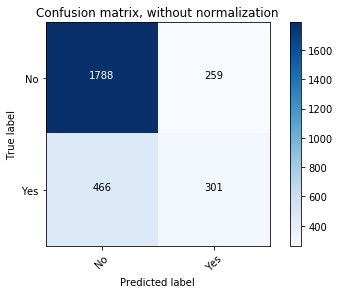

In [54]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.87347338 0.12652662]
 [0.60756193 0.39243807]]


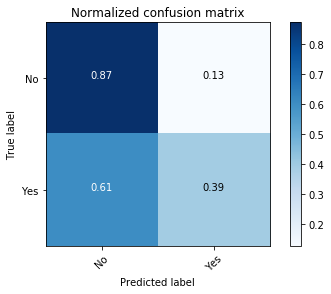

In [55]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()